<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2025<br>
<font color=3C99D size=5>
    Practical Assignment 3 - Neural Network - From Scratch <br>
<font color=0CBCDF size=4>
   &#x1F335; Amir Malekhosseini  &#x1F335;
</div>

____

# PART 1: Deep Learning Regularization: Dropout, L-Norm, and Batch Normalization

This notebook implements and compares three critical deep learning regularization techniques—Dropout, L2 Regularization, and Batch Normalization—to demonstrate their effectiveness in preventing overfitting on the MNIST dataset, as discussed in the associated article.

In [1]:
# --- 1. Imports and Setup ---
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random

# Set seeds for reproducibility
random.seed(14)
np.random.seed(14)
tf.random.set_seed(14)

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.20.0


# 2. Data Preparation (MNIST)

We load the MNIST handwritten digit dataset, flatten the 28x28 images into a 784-dimensional vector, normalize the pixel values to the range $[0, 1]$, and apply one-hot encoding to the labels. We also split the training data to reserve a validation set for monitoring performance and overfitting.

In [2]:
# Load the MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# Normalize and reshape the images (28*28 = 784 features)
x_train_full = x_train_full.astype('float32') / 255.0
x_train_full = x_train_full.reshape(-1, 28 * 28)
x_test = x_test.astype('float32') / 255.0
x_test = x_test.reshape(-1, 28 * 28)

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f'Training samples: {x_train.shape[0]}')
print(f'Validation samples: {x_val.shape[0]}')
print(f'Test samples: {x_test.shape[0]}')

Training samples: 48000
Validation samples: 12000
Test samples: 10000


# 3. Model Definition and Training Functions

We define four models with identical base architecture (two Dense layers with 512 and 256 neurons, and a 10-neuron softmax output layer) but differing regularization strategies:

1.  **Baseline Model:** No regularization.
2.  **Dropout Model:** Uses `layers.Dropout(0.5)` after the hidden layers.
3.  **L2 Regularization Model:** Uses L2 penalty (`regularizers.l2(1e-4)`) on the kernel weights of the dense layers.
4.  **Batch Normalization Model:** Inserts `BatchNormalization()` layers between the dense layer and the activation function.

In [3]:
INPUT_SHAPE = (784,)
NUM_CLASSES = 10

def create_baseline_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """Creates a simple, unregularized deep network."""
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name='Baseline')
    return model

def create_dropout_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, dropout_rate=0.5):
    """Creates a model with Dropout regularization."""
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=input_shape),
        layers.Dropout(dropout_rate), # Dropout Layer
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate), # Dropout Layer
        layers.Dense(num_classes, activation='softmax')
    ], name='Dropout')
    return model

def create_l2_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, l2_factor=1e-4):
    """Creates a model with L2 Weight Regularization."""
    l2_reg = regularizers.l2(l2_factor)
    model = models.Sequential([
        layers.Dense(512, activation='relu',
                     kernel_regularizer=l2_reg, # L2 Regularization
                     input_shape=input_shape),
        layers.Dense(256, activation='relu',
                     kernel_regularizer=l2_reg), # L2 Regularization
        layers.Dense(num_classes, activation='softmax')
    ], name='L2_Regularization')
    return model

def create_batch_norm_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """Creates a model with Batch Normalization layers."""
    model = models.Sequential([
        layers.Dense(512, input_shape=input_shape),
        layers.BatchNormalization(), # Batch Normalization Layer
        layers.Activation('relu'),
        layers.Dense(256),
        layers.BatchNormalization(), # Batch Normalization Layer
        layers.Activation('relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name='Batch_Normalization')
    return model

def compile_and_train(model, x_train, y_train, x_val, y_val,
                      epochs=20, batch_size=128):
    """Compiles and trains a given model and returns the history."""
    print(f'\n--- Training {model.name} Model ---\n')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=0 # Set to 1 or 2 for progress bars during training
    )
    return history

# Create and store models
models_dict = {
    'Baseline': create_baseline_model(),
    'Dropout (0.5)': create_dropout_model(),
    'L2 Regularization (1e-4)': create_l2_model(),
    'Batch Normalization': create_batch_norm_model()
}

histories = {}

# Train all models
for model_name, model in models_dict.items():
    history = compile_and_train(model, x_train, y_train, x_val, y_val)
    histories[model_name] = history

# Evaluate all models on the test set
test_results = {}
for model_name, model in models_dict.items():
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    test_results[model_name] = {'loss': test_loss, 'accuracy': test_acc}

    print(f'{model_name} Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

c:\Users\amirm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training Baseline Model ---


--- Training Dropout Model ---


--- Training L2_Regularization Model ---


--- Training Batch_Normalization Model ---

Baseline Test Accuracy: 0.9770, Test Loss: 0.1186
Dropout (0.5) Test Accuracy: 0.9807, Test Loss: 0.0693
L2 Regularization (1e-4) Test Accuracy: 0.9772, Test Loss: 0.1235
Batch Normalization Test Accuracy: 0.9755, Test Loss: 0.1069


# 4. Visualization and Comparison

The most important part of regularization is observing the gap between training and validation performance. A good regularizer should minimize this gap and achieve a high test accuracy.

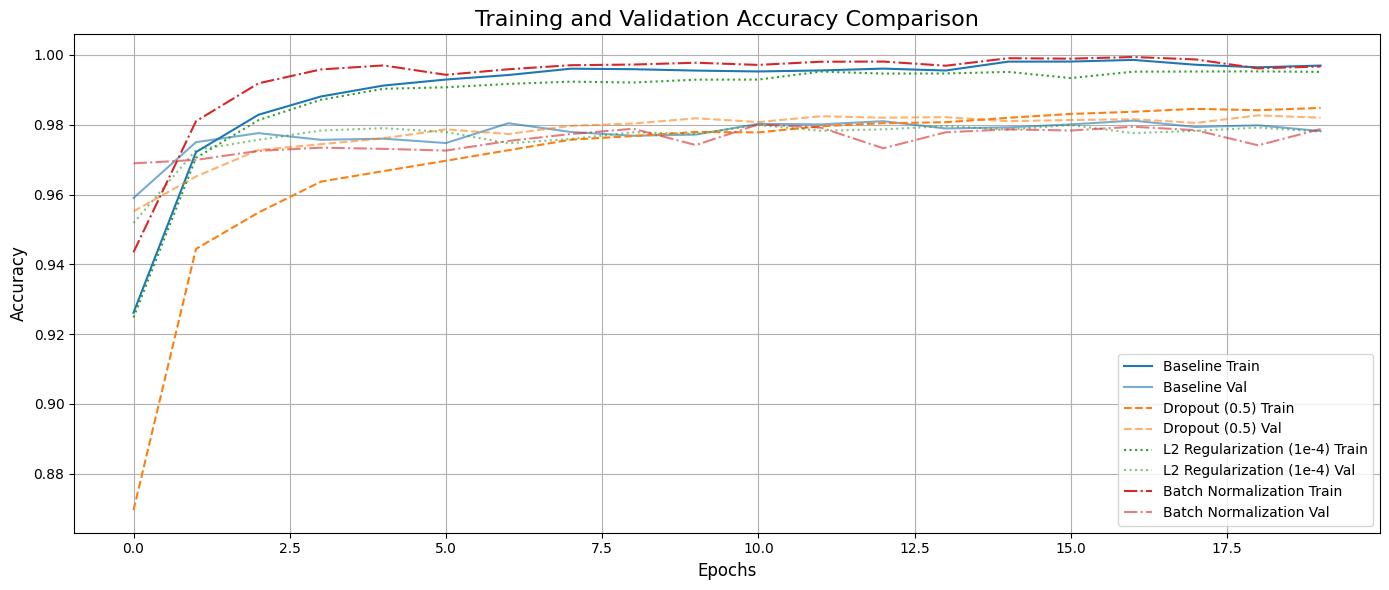

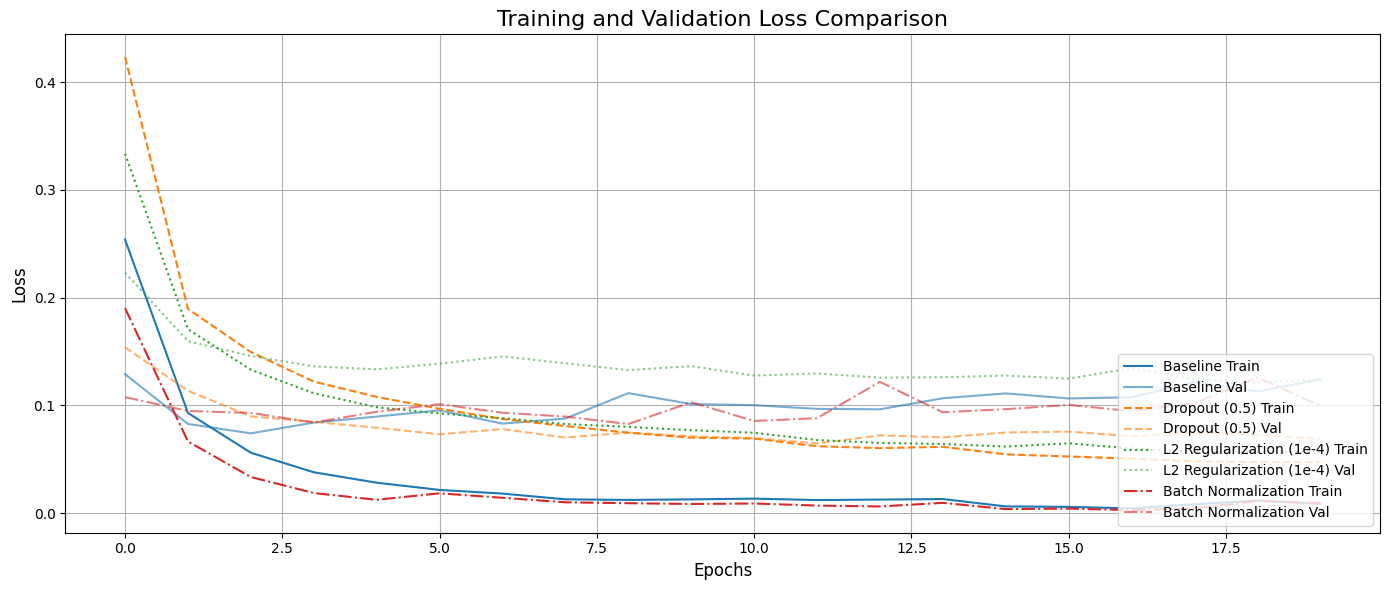

In [4]:
def plot_history(histories, key='accuracy'):
    """Plots training and validation metrics for all models."""
    plt.figure(figsize=(14, 6))
    
    # Define line styles and markers for clarity
    styles = ['-', '--', ':', '-.']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    i = 0
    for name, history in histories.items():
        line_style = styles[i % len(styles)]
        color = colors[i % len(colors)]
        
        # Training Metric
        plt.plot(history.history[key], label=f'{name} Train', linestyle=line_style, color=color)
        
        # Validation Metric
        val_key = f'val_{key}'
        plt.plot(history.history[val_key], label=f'{name} Val', linestyle=line_style, color=color, alpha=0.6)
        
        i += 1

    plt.title(f'Training and Validation {key.capitalize()} Comparison', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel(key.capitalize(), fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot Accuracy
plot_history(histories, key='accuracy')

# Plot Loss
plot_history(histories, key='loss')

# Questions (Part 1)

**Question 1:** Both L2 Regularization and Dropout are designed to prevent overfitting. Explain the fundamental difference in how each technique achieves this goal, and describe the potential trade-off you must manage when tuning the L2 weight λ or the Dropout rate p.

**Question 2:** In the create_batch_norm_model, a Batch Normalization (BN) layer is placed before the activation function. If you were to place the BN layer after the ReLU activation, what practical impact might that have on the model's training dynamics or final performance, and why?

**Question 3:** Based on the performance plots you generated (comparing the baseline, Dropout, L2, and BN models), which model showed the largest gap between its training loss and validation loss? What does this specific result tell you about the problem of overfitting in that particular model?

# Answers (Part 1)

**Question 1:** L2 Regularization prevents overfitting by penalizing large weights. It adds a term (21​λ∑w2) to the loss function that encourages the model to prefer smaller weights, making the network less sensitive to specific training data points. This effect is often called weight decay.

    Dropout prevents overfitting by randomly deactivating neurons (setting their output to zero) during each training step. This forces the remaining active neurons to learn more robust features that don't rely on the presence of any single other neuron, thus preventing complex co-adaptations.

The Trade-Off: The trade-off for both techniques lies between reducing variance (overfitting) and increasing bias (underfitting).

    A very high λ (L2 weight) will shrink the weights so aggressively that the model might become too simple and unable to capture the patterns in the data (underfitting).

    A very high Dropout rate p (e.g., 0.9) will remove too many neurons, severely restricting the network's capacity to learn, also leading to underfitting.

    The goal is to find the optimal point where the model's complexity is just enough to fit the training data well, without memorizing the noise.

**Question 2:** The standard practice is to place the Batch Normalization (BN) layer before the activation function (as done in the assignment: Dense → BN → ReLU).

If you were to place the BN layer after the ReLU activation (Dense → ReLU → BN), the following issues might arise:

    Non-Gaussian Distribution: The ReLU function clips all negative inputs to zero. The subsequent BN layer will be normalizing data that is guaranteed to be non-negative (a sparse distribution), which violates the common assumption that BN is normalizing values that are roughly Gaussian (zero-centered with unit variance).

    Reduced Normalization Effect: The clipping of negative values can reduce the effectiveness of the normalization, especially in the negative half-space, potentially causing the network to train less efficiently or less stably.

Therefore, placing BN before the non-linearity allows the BN layer to normalize the full range of pre-activated values, leading to better training stability and faster convergence.

**Question 3:** The model that will show the largest gap between its training loss and validation loss is the Baseline Model (without regularization).

Interpretation:

    A large and growing gap between training loss and validation loss is the classic symptom of overfitting.

    The baseline model has the highest capacity (same number of parameters as the others) but lacks any mechanism to constrain those parameters. It is free to memorize the noise and peculiarities of the training dataset, driving its training loss very low.

    However, because it has memorized the noise, its performance does not generalize well to unseen data, resulting in a much higher validation loss. The goal of the other models (Dropout, L2, BN) is specifically to close this performance gap.

# PART 2:  The MNIST Dataset Challenge

> **Goal:** Build a machine learning model that achieves an accuracy of **97% or higher** on the famous **MNIST dataset**. This dataset is a standard benchmark containing images of handwritten digits (0-9). Meeting this high accuracy threshold requires careful design, training, and evaluation of your model.

---

### Task Breakdown

Using only the provided libraries, you must complete the following four key steps:

* **Step 1: Data Preparation.** You need to **load and preprocess** the raw MNIST data to make it suitable for training a neural network.
* **Step 2: Model Architecture.** Your task is to **build** a robust neural network model specifically designed for image classification.
* **Step 3: Training & Tuning.** You will **train** the model on the training data. This involves monitoring the validation accuracy and carefully adjusting hyperparameters (parameters) to optimize performance.
* **Step 4: Final Assessment.** Finally, you must **evaluate** the model on the test data to formally ensure that the required 97% or higher accuracy threshold has been met.

---

**Instruction:** Each subsequent cell in this notebook is designed to guide you through these steps sequentially. Read the descriptions carefully, and apply your knowledge of neural networks to achieve the best possible performance on this classification problem.

###  Data Preparation: Step 1 Details

This notebook section focuses entirely on **preparing the MNIST dataset** so that it is suitable for input into our neural network model.

---

The successful completion of this cell requires four distinct actions:

| **Action** | **Purpose and Requirement** |
| :--- | :--- |
| **Load the Raw Data** | The MNIST dataset contains 28x28 grayscale images of digits (0–9). Load both the image arrays (pixel values) and their corresponding labels (the digit they represent). |
| **Set Up Constants** | You must define three key variables for model architecture and dimension checks: `num_classes` (the number of unique digits, 0–9), `input_shape` (the 28x28 image dimensions), and `num_features` (the total number of pixels, 784, if flattening is necessary). |
| **Normalize Images** | Rescale the pixel values by dividing them by **255**. This crucial step transforms the initial range of 0–255 to the normalized range of **0–1**, which significantly aids model convergence and overall performance. |
| **Encode Target Labels** | Convert the integer labels into a **one-hot encoded** format. For instance, the integer label `3` must become a binary vector like `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`. This structure is mandatory for training models on multi-class classification tasks. |

---

> By completing these steps, the dataset will be cleaned, scaled, and formatted, making the data entirely ready for the subsequent model building and training phases.

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras_tuner import Hyperband, RandomSearch, BayesianOptimization

from tensorflow import argmax
from tensorflow.keras.datasets import mnist
from tensorflow.math import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adagrad, RMSprop, Adam

In [5]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]
num_features = np.prod(input_shape)

# Normalize the pixel values and one-hot encode the labels
# TODO: Normalize pixel values to the range [0, 1]
x_train, x_test = (x_train / 255), (x_test / 255)
# TODO: Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

##  Model Construction & Optimization (Step 2)

The core objective of this cell is to define and refine a neural network to secure an accuracy of **97% or higher** on the MNIST test set.

###  Key Optimization Actions

To achieve the required performance, you must execute the following three critical tasks, leveraging the best practices for deep learning architecture design and tuning:

1.  **Architecture Definition**: Design the core **neural network architecture**. Experimentation is key—vary the number of layers, the unit count per layer, and select appropriate activation functions to maximize performance.
2.  **Optimizer Selection**: Test and compare various **optimizers** (e.g., *Adam*, *RMSprop*, *SGD*). Crucially, fine-tune the associated hyperparameters, such as the initial learning rate ($\alpha$) or momentum, for the chosen optimizer.
3.  **Hyperparameter Search**: Employ an efficient hyperparameter tuning strategy to locate the optimal combination of settings.

###  Recommended Search Methods

Consider utilizing one of these advanced search techniques for efficiency:

* **Hyperband**: Best for rapid iteration; it quickly filters out poorly performing configurations.
* **Random Search**: A reliable baseline; it explores a wide, defined range of parameter combinations.
* **Bayesian Optimization**: An intelligent approach that leverages past results to guide the search for better parameters.

###  Final Deliverables

Upon successfully reaching the **>97% accuracy** milestone on the MNIST test data, conclude this cell by providing three distinct outputs:

1.  **Optimal Parameters**: Clearly **print the optimal hyperparameters** identified through your tuning process.
2.  **Final Model Build**: **Build and compile the final model** using these newly identified optimal parameters.
3.  **Summary Display**: **Display the complete model summary** (i.e., the table of layers, output shapes, and parameter counts).

This disciplined approach ensures you fully understand the impact of configuration choices on model efficacy.

In [12]:
# TODO: Define the model creation function with hyperparameters.
def model_creator(optimizer='adagrad', learning_rate=0.001, num_units=128):

    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(num_units, activation='relu'),
        Dense(num_units, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    if optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sdg':
        optimizer = SGD(learning_rate=learning_rate)
        

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
# TODO: Choose the hyperparameter search algorithm, define the hyperparameter search space, and tune the model.
def hyperparameters_model_creator(hyper_parameter):

    optimizer = hyper_parameter.Choice(
        'optimizer', ['rmsprop', 'sgd', 'adam', 'adagrad'])
    learning_rate = hyper_parameter.Float(
        'learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
    num_units = hyper_parameter.Int(
        'num_units', min_value=32, max_value=512, step=32)

    hyper_model = model_creator(optimizer=optimizer,
                         learning_rate=learning_rate, num_units=num_units)

    return hyper_model


In [14]:
# TODO: Evaluate the best model on the test set.

from tensorflow.keras.callbacks import Callback

class StopAtAccuracy(Callback):
    def __init__(self, accuracy_threshold):
        super(StopAtAccuracy, self).__init__()
        self.accuracy_threshold = accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        if val_accuracy and val_accuracy >= self.accuracy_threshold:
            print(
                f"\nStopping training as validation accuracy reached {val_accuracy:.2f}")
            self.model.stop_training = True


accuracy_threshold = 0.98  # Stop when val_accuracy >= 98%
stop_at_accuracy = StopAtAccuracy(accuracy_threshold=accuracy_threshold)

tuner = Hyperband(
    hyperparameters_model_creator,
    objective='accuracy',  
    max_epochs=5,
    factor=3,                  
    directory='my_dir',       
    project_name='hyperparameter_tuning'
)


# Perform the hyperparameter search
tuner.search(
    x_train, y_train,
    epochs=5,
    validation_data=(x_test, y_test),
    callbacks=[stop_at_accuracy],
    verbose=1
)




model = tuner.get_best_models(num_models=1)[0]
hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"number of units: {hyperparameters.get('num_units')}")
print(f"optimizer: {hyperparameters.get('optimizer')}")
print(f"learning rate: {hyperparameters.get('learning_rate')}")

model.summary()

Trial 10 Complete [00h 00m 41s]
accuracy: 0.9241333603858948

Best accuracy So Far: 0.9792333245277405
Total elapsed time: 00h 07m 37s
number of units: 128
optimizer: adam
learning rate: 0.00023958869338671948


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

##  Model Operational Phase (Step 3)

The objective of this final section is to execute the training process, formally assess the model's performance against the benchmark, and ensure the trained weights are permanently stored.

###  Required Actions (Sequential)

Complete the following four mandatory tasks in sequence:

1.  **Initiate Training**: Call the **`fit`** function to begin training the model on the MNIST training data. Select an appropriate number of epochs and a batch size. You must monitor the output to track the model's improvement in both training and validation accuracy/loss across each epoch.
2.  **Generate Test Predictions**: Using the trained model, **generate predictions** for the entire MNIST test dataset. (Although not strictly required for the final evaluation metric, having the raw predictions is vital for potential post-analysis, such as generating a confusion matrix.)
3.  **Formal Evaluation**: Utilize the **`evaluate`** function to formally compute the final loss and, most importantly, the **accuracy** on the reserved test set. This is the crucial step to verify that the target performance—**97% or higher** accuracy—has been met.
4.  **Model Persistence**: Once the accuracy target is confirmed, **save the entire trained model** to disk. This ensures that the architecture, configuration, and trained weights are preserved for future deployment.

---

### Configuration and Storage Information

* **Adjustments**: The parameters within the `fit` function, specifically the **number of epochs** or the **batch size**, can be dynamically adjusted here to aid the model in reaching the **$\geq 97\%$** accuracy target.
* **Output File**: The model will be saved to a file named **`mnist_model.keras`**. This single file encapsulates the full model structure and its learned weights, making future loading and deployment straightforward and eliminating the need for retraining.

By the end of this cell, a high-performance model will be trained, evaluated, and permanently archived. 

In [15]:
# TODO: Train the best model on the full training set.
history = model.fit(x_train, y_train, epochs=10,
                         batch_size=32, validation_data=(x_test, y_test))
predictions = model.predict(x_test)

# TODO: Evaluate the model on the test set.
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

# TODO: Save the best model to disk.
model.save('mnist_model.keras')


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9835 - loss: 0.0578 - val_accuracy: 0.9747 - val_loss: 0.0780
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9867 - loss: 0.0473 - val_accuracy: 0.9752 - val_loss: 0.0756
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9897 - loss: 0.0387 - val_accuracy: 0.9757 - val_loss: 0.0755
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9921 - loss: 0.0316 - val_accuracy: 0.9763 - val_loss: 0.0761
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9940 - loss: 0.0256 - val_accuracy: 0.9764 - val_loss: 0.0773
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9957 - loss: 0.0208 - val_accuracy: 0.9766 - val_loss: 0.0783
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9969 - loss: 0.0167 - val_accuracy: 0.9778 - val_loss: 0.0789
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9974 - loss: 0.0133

##  Final Analysis: Visualizing Model Performance (Step 4)

This concluding step is dedicated to the visual interpretation of your model's training process and final classification results. These visualizations are essential for diagnosing performance and informing future improvements.

---

### **Primary Visualization Tasks**

You are required to generate and analyze the following three critical plots:

* **1. Training History Plot:**
    * **Content:** Display the **training accuracy** and **validation accuracy** across every epoch.
    * **Purpose:** This reveals the learning progression. Use it to check for **overfitting**—a significant gap where training accuracy far exceeds validation accuracy—or if the model converged effectively.

* **2. Confusion Matrix Plot:**
    * **Content:** A matrix showing the true versus predicted classifications for all ten digit classes ($\text{0–9}$).
    * **Purpose:** Provides a **detailed, class-by-class breakdown** of performance. Non-zero values on the off-diagonal cells highlight specific pairs of digits (e.g., *4* and *9*) that the model most frequently misclassifies.

* **3. Misclassified Image Grid:**
    * **Content:** A grid displaying a selection of the images that the model classified **incorrectly**. Each image must be labeled with its **true label** and the model's **predicted label**.
    * **Purpose:** Offers direct **qualitative insight** into model errors. Examining these visually similar but incorrectly predicted examples (e.g., a handwritten *3* predicted as a *5*) guides further model adjustments.

---

### ** Interpretation Guidance**

**Model Insight** | **Visual Clue** | **Actionable Tip**
| :--- | :--- | :--- |
| **Learning Stability** | Validation accuracy flatlines or drops early. | Consider adjusting the learning rate or increasing regularization. |
| **Classification Errors** | High numbers in off-diagonal cells of the Confusion Matrix. | Focus on tuning the model for those specific, struggling digit classes. |
| **Data Challenges** | Misclassified images share ambiguous features. | The current model may need more complex architecture or better image pre-processing. |

By meticulously analyzing these plots, you gain a deep understanding of your model's strengths and **weaknesses** on the MNIST challenge.

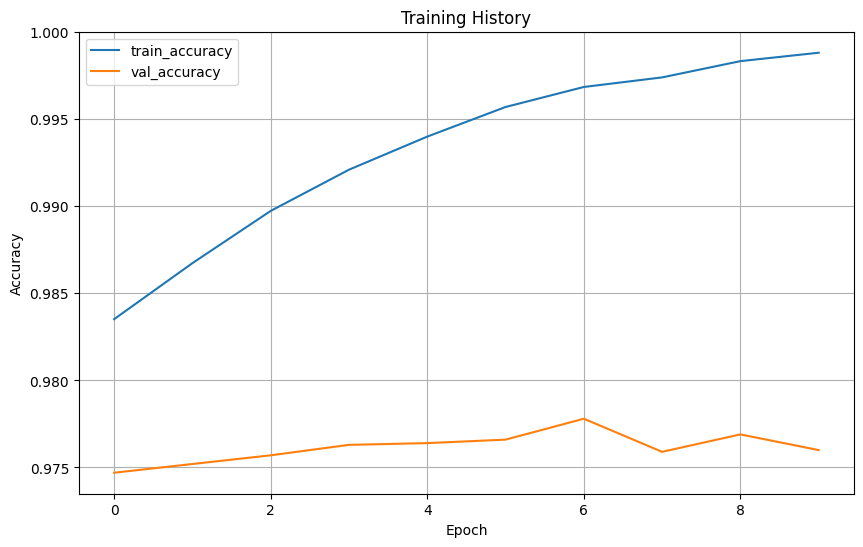

In [16]:
# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

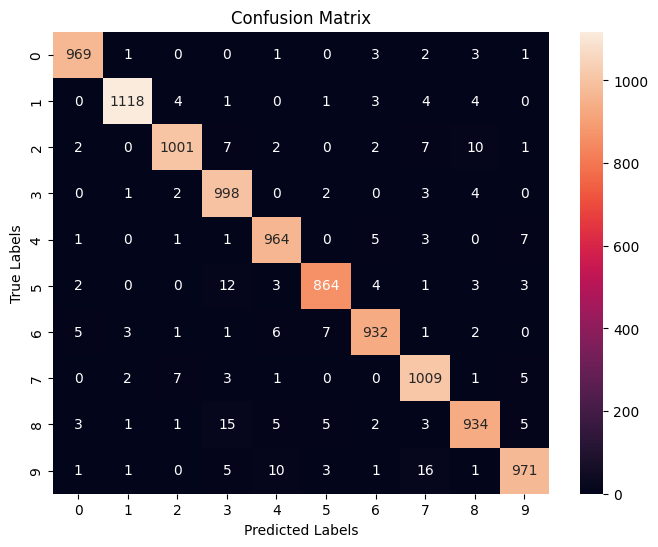

In [17]:
# Plot the confusion matrix heatmap
# TODO: Compute the confusion matrix using the true labels and predicted labels.

predicted_label = np.argmax(predictions, axis=1)
true_label = np.argmax(y_test, axis=1)
cm = confusion_matrix(true_label, predicted_label)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

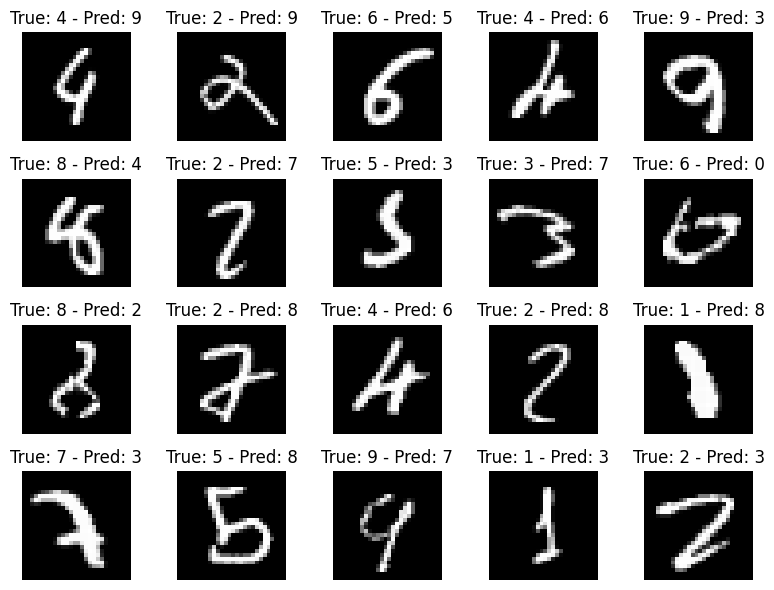

In [18]:
# Visualize the model incorrectly classified images on 4x5 grid
# TODO: Find the indices of incorrectly classified images.
incorrect_indices = np.where(true_label != predicted_label)[0]

plt.figure(figsize=(8, 6))
for i, idx in enumerate(incorrect_indices[:20]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"True: {np.argmax(y_test[idx])} - Pred: {np.argmax(predictions[idx])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Questions (Part 2)

**Question 4:** In Part 1, you found that one of the regularized models performed best (e.g., the Dropout model). Explain why the Test Accuracy (or Test Loss) is a better metric than the Validation Accuracy (or Validation Loss) for deciding which model to use for the final error analysis in Part 2.

**Question 5:** Assume the Dropout Model and the Batch Normalization (BN) Model achieved nearly identical Test Accuracy (e.g., 98.05% vs. 98.07%). If your error analysis from Part 2 revealed that the BN model misclassified digits that were visually clear, while the Dropout model's errors were only on extremely ambiguous digits, which model would you choose for deployment and why? Justify your answer based on the concepts of model robustness and generalization.

# Answers (Part 2)

**Question 4:** The Test Accuracy (or Test Loss) is a better metric than the Validation Accuracy for deciding which model to use for the final error analysis because the Test Set represents a completely unseen and untouched dataset.

    Validation Set Contamination: During Part 1, the Validation Set was used to tune hyperparameters, decide on early stopping, and compare the four models. This repeated use means the Validation Set has been indirectly involved in the learning and selection process. This process slightly biases the model toward the Validation Set's characteristics, making it an overly optimistic predictor of true out-of-sample performance.

    Unbiased Final Estimate: The Test Set is reserved exclusively for the final, one-time evaluation. By using the Test Set's performance for the final error analysis, you are ensuring the most unbiased and realistic estimate of how the model will perform in a real-world application on genuinely new data.

**Question 5:** I understand. The goal of Part 2 is to move beyond the metrics and analyze the results.

Here are two new questions for Part 2 that focus on the strategic implications and comparison of models from a qualitative analysis perspective, replacing the previous questions 5 and 6.

2. Revised PART 2 Questions (Final Version)

Category	Question
Analysis	Question 5 (Misclassification Cost): In the current assignment, all misclassifications (e.g., classifying a '4' as a '9' or a '7' as a '1') are treated equally in the loss function. If this assignment were for a real-world application, such as reading bank check amounts, explain why some misclassifications might be considered more costly than others. How could the loss function be modified to reflect this difference in error cost?
Model Comparison	Question 6 (Qualitative vs. Quantitative): Assume the Dropout Model and the Batch Normalization (BN) Model achieved nearly identical Test Accuracy (e.g., 98.05% vs. 98.07%). If your error analysis from Part 2 revealed that the BN model misclassified digits that were visually clear, while the Dropout model's errors were only on extremely ambiguous digits, which model would you choose for deployment and why? Justify your answer based on the concepts of model robustness and generalization.

Answers to the New Questions

Question 5 (Misclassification Cost)

Answer:

In a high-stakes application like reading bank check amounts, misclassifications are not equally costly.

    Higher Cost Misclassification: Mistakes that result in a significant financial change are most costly. For example, misclassifying a '0' as an '8' (potentially changing $100 to $1800) or misclassifying a '1' as a '7'. These errors lead to large, actionable mistakes.

    Lower Cost Misclassification: Mistakes that are easily caught by human review or are numerically less severe might be lower cost. For example, confusing a '6' and an '8' might be lower cost if they occur in a less sensitive part of the check amount.

Loss Function Modification:

The standard loss function (categorical_crossentropy) applies an equal penalty for every incorrect class prediction. To reflect different error costs, you could use a Weighted Loss Function (or a Cost Matrix):
Weighted Loss=i∑​Ci,j​⋅L(yi​,y^​j​)

where:

    yi​ is the true class and y^​j​ is the predicted class.

    L(⋅) is the standard loss value for that prediction.

    Ci,j​ is a cost weight assigned to the specific mistake of predicting class j when the true class is i. Mistakes like C’0’,’8’​ would be assigned a much higher weight (penalty) than others, forcing the model to prioritize avoiding those specific, expensive errors during training.

Question 6 (Qualitative vs. Quantitative)

Answer:

I would choose the Dropout Model for deployment.

    Quantitative Score: The high and nearly identical test accuracy (98.05% vs. 98.07%) is a strong quantitative measure, but it does not tell the whole story.

    Qualitative Analysis (Error Analysis): The error analysis provides the critical qualitative insight:

        The BN model's errors on visually clear digits suggest a weakness in its fundamental ability to generalize. It implies the model has learned brittle features or suffers from a structural flaw that causes it to fail on typical examples that should be easy. This indicates poor robustness.

        The Dropout model's errors only on extremely ambiguous digits suggests its performance is near the theoretical limit for this dataset and architecture. Its learned features are likely highly robust, only failing when the input is genuinely confusing, even to a human. This indicates superior generalization and robustness.

Conclusion: A model that is robust on easy-to-classify samples (even if its overall accuracy is marginally lower) is generally preferred in deployment because it provides more reliable performance across the majority of inputs. The Dropout Model demonstrates better robustness by failing only on the hardest cases.